In [1]:
import numpy as np

import matplotlib.pyplot as plt

import gymnasium as gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
gym.__version__

'0.29.0'

# Enviroment

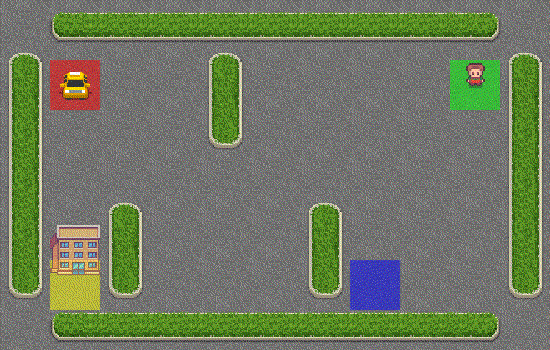

https://www.gymlibrary.dev/environments/toy_text/taxi/

В среде Taxi должно забирать пассажиров и доставлять их в пункт назначения на небольшой стоянке, двигаясь по кратчайшему пути. 

## $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [5]:
np.ones(4)*0.9/4

array([0.225, 0.225, 0.225, 0.225])

In [3]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    
    return np.random.choice(np.arange(action_n), p=policy)

## Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [5]:
env.reset()

(13, {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)})

In [6]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    total_rewards = []  # Создаем список для хранения общих вознаграждений для каждого эпизода
    
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде
    qfunction = np.zeros((state_n, action_n))  # Создаем Q-функцию (матрицу состояние-действие) и инициализируем её нулями
    counter = np.zeros((state_n, action_n))  # Создаем счетчик для подсчета количества визитов в каждую ячейку Q-функции
    
    for episode in range(episode_n):  # Запускаем цикл для каждого эпизода
        epsilon = 1 - episode / episode_n  # Уменьшаем параметр epsilon для epsilon-жадной стратегии с каждым эпизодом
        trajectory = {'states': [], 'actions': [], 'rewards': []}  # Создаем структуру данных для хранения траектории эпизода
        
        state = env.reset()[0]  # Сбрасываем среду и получаем начальное состояние
        for _ in range(trajectory_len):  # Запускаем цикл для каждого шага внутри эпизода (ограниченного trajectory_len)
            trajectory['states'].append(state)  # Добавляем текущее состояние в траекторию
            
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)  # Получаем действие с использованием epsilon-жадной стратегии
            trajectory['actions'].append(action)  # Добавляем текущее действие в траекторию
            
            state, reward, done, _, _ = env.step(action)  # Выполняем выбранное действие и получаем следующее состояние, вознаграждение и флаг завершения
            trajectory['rewards'].append(reward)  # Добавляем полученное вознаграждение в траекторию
            
            if done:  # Если эпизод завершился, выходим из цикла
                break
                
        total_rewards.append(sum(trajectory['rewards']))  # Добавляем суммарное вознаграждение текущего эпизода в список
        
        real_trajectory_len = len(trajectory['rewards'])  # Определяем реальную длину траектории (может быть меньше trajectory_len, если эпизод завершился раньше)
        returns = np.zeros(real_trajectory_len + 1)  # Создаем массив для хранения возвращений (returns) на каждом шаге траектории
        
        for t in range(real_trajectory_len - 1, -1, -1):  # Запускаем цикл для вычисления возвращений для каждого шага в траектории (в обратном порядке)
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]  # Вычисляем возвращение с учетом дисконтирования (gamma)
            
        for t in range(real_trajectory_len):  # Запускаем цикл для обновления Q-функции на каждом шаге в траектории
            state = trajectory['states'][t]  # Получаем текущее состояние
            action = trajectory['actions'][t]  # Получаем текущее действие
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])  # Обновляем Q-функцию согласно формуле метода Монте-Карло
            counter[state][action] += 1  # Увеличиваем счетчик визитов для соответствующей ячейки Q-функции
            
    return total_rewards  # Возвращаем список общих вознаграждений для каждого эпизода


## Solving "Taxi" enviroment with Monte-Carlo method

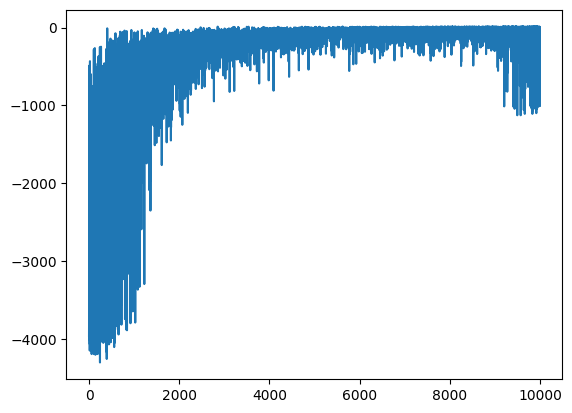

In [7]:
env = gym.make("Taxi-v3")

total_rewards = MonteCarlo(env, episode_n=10000, trajectory_len=1000, gamma=0.99)

plt.plot(total_rewards)
plt.show()

## SARSA Algorithm 
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [7]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)  # Создаем массив для хранения общих вознаграждений для каждого эпизода
    
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде
    qfunction = np.zeros((state_n, action_n))  # Создаем Q-функцию (матрицу состояние-действие) и инициализируем её нулями
    
    for episode in range(episode_n):  # Запускаем цикл для каждого эпизода
        epsilon = 1 / (episode + 1)  # Уменьшаем параметр epsilon для epsilon-жадной стратегии с каждым эпизодом
        
        state = env.reset()[0]  # Сбрасываем среду и получаем начальное состояние
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)  # Получаем действие с использованием epsilon-жадной стратегии
        
        for _ in range(trajectory_len):  # Запускаем цикл для каждого шага внутри эпизода (ограниченного trajectory_len)
            next_state, reward, done, _, _ = env.step(action)  # Выполняем выбранное действие и получаем следующее состояние, вознаграждение и флаг завершения
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)  # Получаем следующее действие с использованием epsilon-жадной стратегии
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])  # Обновляем Q-функцию согласно формуле метода SARSA
            
            state = next_state  # Переходим в следующее состояние
            action = next_action  # Переходим в следующее действие
            
            total_rewards[episode] += reward  # Добавляем полученное вознаграждение к общему вознаграждению текущего эпизода
            
            if done:  # Если эпизод завершился, выходим из цикла
                break

    return total_rewards  # Возвращаем массив общих вознаграждений для каждого эпизода

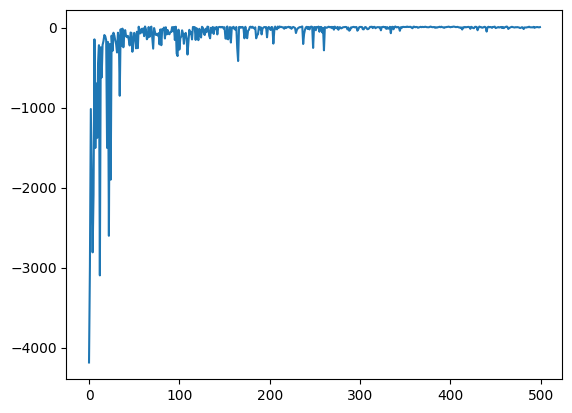

In [8]:
total_rewards = SARSA(env, episode_n=500, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

### Q-Learning Algorithm

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [6]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)  # Создаем массив для хранения общих вознаграждений для каждого эпизода
    
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде
    Q = np.zeros((state_n, action_n)) # Создаём Q таблицу, размером (state_n, action_n), инициализируем нулями
    
    
    for episode in range(episode_n):  # Запускаем цикл для каждого эпизода
        epsilon = 1 / (episode + 1)  # Уменьшаем параметр epsilon для epsilon-жадной стратегии с каждым эпизодом
        
        state = env.reset()[0]  # Сбрасываем среду и получаем начальное состояние
        
        for _ in range(trajectory_len):  # Запускаем цикл для каждого шага внутри эпизода (ограниченного trajectory_len)
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)  # Получаем действие с использованием epsilon-жадной стратегии
            next_state, reward, done, _, _ = env.step(action)  # Выполняем выбранное действие и получаем следующее состояние, вознаграждение и флаг завершения
                   
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])  # Обновляем Q-функцию согласно формуле метода SARSA

            total_rewards[episode] += reward  # Добавляем полученное вознаграждение к общему вознаграждению текущего эпизода
            
            if done:  # Если эпизод завершился, выходим из цикла
                break
            state = next_state  # Переходим в следующее состояние

    return total_rewards, Q  # Возвращаем массив общих вознаграждений для каждого эпизода

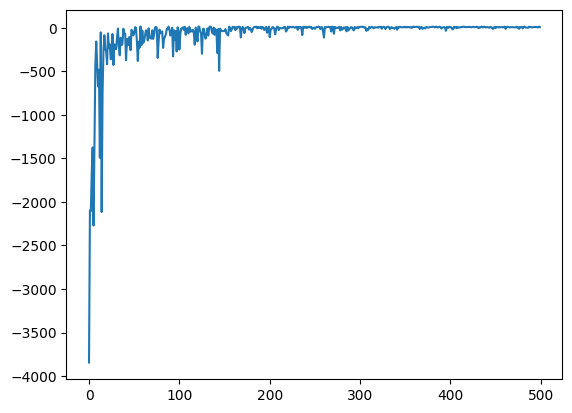

In [9]:
total_rewards, Qtable = QLearning(env, episode_n=500, noisy_episode_n=400, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

Посмотрим на результат с использованием итоговой Q таблицы

Saved video.
Moviepy - Building video video_result.mp4.
Moviepy - Writing video video_result.mp4



Moviepy - Done !
Moviepy - video ready video_result.mp4
Sequence = [3, 1, 4, 2, 0, 0, 2, 2, 0, 0, 5]


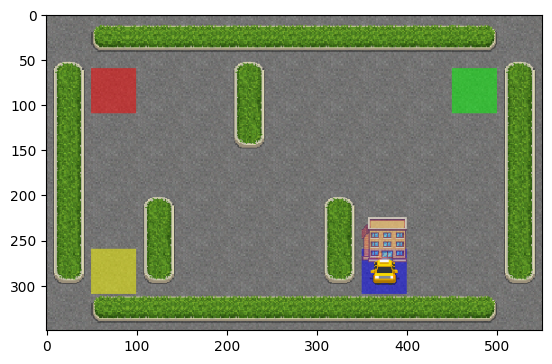

In [11]:
from IPython.display import clear_output
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython import display
import time 
import pygame

video_path = "video_result.mp4"
video_recorder = VideoRecorder(env, video_path, enabled=video_path is not None)


state = env.reset()[0]
plt.imshow(env.render())
display.display(plt.gcf())
display.clear_output(wait=True)
done = False
sequence = []

while not done:
    env.unwrapped.render()
    video_recorder.capture_frame()
    # Выбор действия по максимальному значению Q
    if np.max(Qtable[state]) > 0:
        action = np.argmax(Qtable[state])

    # если везде нули -> выберем случайно
    else:
        action = env.action_space.sample()
    
    # добавим действие в последовательность
    sequence.append(action)

    # Выполним действие и получим обратную связь от среды
    new_state, reward, done, _, _ = env.step(action)
    
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    # обновим состояние
    state = new_state

    time.sleep(0.5)
print("Saved video.")
video_recorder.close()
video_recorder.enabled = False
env.close()

print(f"Sequence = {sequence}")

# Сравнение методов.

Методы SARSA и Q-learning являются более эффективными и удобными по сравнению с методом Монте-Карло в контексте обучения с подкреплением по следующим причинам:

- __Онлайн обучение:__ SARSA и Q-learning работают в режиме онлайн, что означает, что они обновляют оценки Q-функции на каждом шаге в процессе взаимодействия с средой. В отличие от метода Монте-Карло, который требует завершения полного эпизода, методы SARSA и Q-learning обновляются по мере получения новых данных, что делает их более эффективными и подходящими для длительных эпизодов или непрерывных взаимодействий с средой.

- __Оценка действий:__ В методе Монте-Карло для оценки Q-функции требуется собирать статистику о возвращениях после каждого действия, что может быть дорого в случае длительных эпизодов или множественных вариантов действий. В методах SARSA и Q-learning оценка Q-функции происходит в режиме онлайн, и нет необходимости ждать завершения эпизода для обновления оценок.

- __Off-policy и On-policy:__ SARSA и Q-learning представляют собой различные подходы к обучению с подкреплением, которые могут быть применены как для off-policy (например, Q-learning), так и для on-policy (например, SARSA) методов управления. В то время как метод Монте-Карло обычно используется только в онлайн-подходе и может быть менее гибким для решения различных задач.
- __Бутстрэпинг:__ Как SARSA, так и Q-learning используют бутстрэпинг (bootstrapping), что означает использование собственных оценок для обновления оценок Q-функции. Это позволяет использовать текущие оценки для обновления других оценок, что может привести к более быстрой сходимости.

- __Оценка вероятностей:__ В методе Монте-Карло требуется оценить вероятности переходов между состояниями, что может быть сложной задачей для некоторых сред. Методы SARSA и Q-learning обходят эту проблему, оценивая вероятности переходов "на лету" через текущие действия и оценки Q-функции.


В целом, методы SARSA и Q-learning обладают большей гибкостью, более эффективными методами обновления оценок Q-функции и работают в режиме онлайн, что делает их предпочтительными в большинстве практических сценариев обучения с подкреплением.

Несмотря на преимущества методов SARSA и Q-learning, они также имеют свои недостатки по сравнению с методом Монте-Карло:

- __Смещение оценок:__ Методы SARSA и Q-learning используют бутстрэпинг для обновления оценок Q-функции, что может привести к смещению оценок. Это означает, что они могут быть менее стабильными в некоторых ситуациях и могут давать оценки, которые не совпадают с истинными значениями Q-функции.
- __Проблема исследования:__ Как SARSA, так и Q-learning применяют жадную стратегию выбора действий с использованием текущих оценок Q-функции. Это может привести к проблеме исследования, когда алгоритм предпочитает выбирать уже известно хорошие действия, игнорируя другие действия, которые могут привести к лучшим вознаграждениям в долгосрочной перспективе.
- __Выбор оптимальной стратегии:__ В отличие от метода Монте-Карло, который обновляет оценки Q-функции только по завершении эпизода, методы SARSA и Q-learning обновляют оценки на каждом шаге внутри эпизода. Это означает, что они могут обучать Q-функцию для неполных траекторий, что может затруднить выбор оптимальной стратегии.
- __Проблема планирования:__ Методы SARSA и Q-learning не решают проблему планирования, т.е. способности выбирать наилучшие действия в неизвестных состояниях. Они обновляют Q-функцию только на основе текущих наблюдений и вознаграждений, но не строят планы на будущее.
- __Обновление весов:__ Параметры методов SARSA и Q-learning обновляются на каждом шаге, что может привести к колебаниям и нестабильности обучения. В методе Монте-Карло веса обновляются только после завершения эпизода, что может сделать обучение более стабильным.


Выбор между методами SARSA, Q-learning и Monte-Carlo зависит от конкретной задачи обучения с подкреплением и характеристик среды. Вот некоторые рекомендации о том, в каких случаях выбрать каждый метод:

- __SARSA:__
 SARSA является on-policy методом, что означает, что он обновляет оценки Q-функции на основе текущей стратегии. В таких ситуациях, когда у вас есть ограниченное количество итераций или желание сохранить стабильность обучения, SARSA может быть предпочтительным выбором.
 Если у вас есть проблема исследования (например, в среде с множеством неизвестных состояний и действий), SARSA может быть полезным, так как он использует текущую стратегию и имеет меньшую вероятность выбирать оптимальные действия сразу, что может помочь исследовать среду.

- __Q-learning:__
Q-learning является off-policy методом, что означает, что он обновляет оценки Q-функции, используя жадную стратегию, но выбирает действия для обучения, исходя из другой стратегии (например, epsilon-жадной стратегии). Если у вас есть информация о наилучшей стратегии или есть возможность исследовать окружение с использованием других стратегий, Q-learning может быть предпочтительным выбором.
Когда у вас есть много данных и необходимость обучать на большом объеме информации, Q-learning может быть более эффективным, так как он обновляет Q-функцию в режиме онлайн и может быстрее сходиться.

- __Monte-Carlo:__
Метод Monte-Carlo часто используется, когда у вас есть длительные эпизоды и вы не можете себе позволить делать обновления Q-функции на каждом шаге. В этом случае Monte-Carlo может быть более эффективным, так как он обновляет Q-функцию только после завершения эпизода.
Если ваша задача связана с оценкой вероятностей или оценкой ценности состояний, метод Monte-Carlo может быть более подходящим, так как он не требует априорной информации о вероятностях переходов и вознаграждениях.
